In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

## Data Summary

In [2]:
df = pd.read_csv("amazon_delivery.csv")

In [3]:
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


In [4]:
df.shape

(43739, 16)

This has 43739 observations and 16 columns. <br>
The delivery time is a potential target variable

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


There are 9 categorical variables and 7 numerical variables

## Objective Of The Analysis

In this Analysis, we are keeping delivery time as the target variable, and using other features like agent age, mode of delivery, delivery time, we are aiming to predict the delivery time

For this analysis:
 - Order Id is irrelevant, so we will be removing it.
 - combine the four features: store latitude, store longitude, drop latitude, drop longitude to a single feature called distance.
 - transform and split the date column to day of the week column and month column.

## Data Cleaning

Handling missing values

In [6]:
for column in df.columns:
    if df[column].isna().sum() > 0:
        print(column)


Agent_Rating
Weather


So only 2 columns, Agent_Rating and Weather have null data

In [7]:
df["Agent_Rating"].isna().sum()

54

In [8]:
df["Weather"].isna().sum()

91

In [9]:
df[df["Weather"].isna() & df["Agent_Rating"].isna()]

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category


So, there is no overlap, and in total there are 145 records with missing value, since this contributes only 0.33% of our total dataset, we can drop it

In [10]:
df.dropna(inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43594 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43594 non-null  object 
 1   Agent_Age        43594 non-null  int64  
 2   Agent_Rating     43594 non-null  float64
 3   Store_Latitude   43594 non-null  float64
 4   Store_Longitude  43594 non-null  float64
 5   Drop_Latitude    43594 non-null  float64
 6   Drop_Longitude   43594 non-null  float64
 7   Order_Date       43594 non-null  object 
 8   Order_Time       43594 non-null  object 
 9   Pickup_Time      43594 non-null  object 
 10  Weather          43594 non-null  object 
 11  Traffic          43594 non-null  object 
 12  Vehicle          43594 non-null  object 
 13  Area             43594 non-null  object 
 14  Delivery_Time    43594 non-null  int64  
 15  Category         43594 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.7+ MB


Handling Duplicates

In [12]:
df.duplicated().sum()

0

There are no duplicate records

Column Transformations

In [13]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2)**2 + \
        math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c  # in kilometers
    return distance

df["Distance"] = df.apply(lambda row: haversine(row['Store_Latitude'], row['Store_Longitude'], row['Drop_Latitude'], row['Drop_Longitude']), axis=1)

In [14]:
df.drop(columns = ['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude'], axis = 1, inplace = True)

In [15]:
df.drop(columns = ['Order_ID'], axis = 1, inplace = True)

In [16]:
df["Order_Day"] = pd.to_datetime(df["Order_Date"]).dt.dayofweek
df["Order_Month"] = pd.to_datetime(df["Order_Date"]).dt.month_name()

In [17]:
df.drop(columns = ["Order_Date"], inplace = True)

In [18]:
df.head()

,Agent_Age,Agent_Rating,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Order_Day,Order_Month
0,37,4.9,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing,3.025149,5,March
1,34,4.5,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530,4,March
2,23,4.4,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758,5,March
3,38,4.7,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401,1,April
4,32,4.6,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138,5,March


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43594 entries, 0 to 43738
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Agent_Age      43594 non-null  int64  
 1   Agent_Rating   43594 non-null  float64
 2   Order_Time     43594 non-null  object 
 3   Pickup_Time    43594 non-null  object 
 4   Weather        43594 non-null  object 
 5   Traffic        43594 non-null  object 
 6   Vehicle        43594 non-null  object 
 7   Area           43594 non-null  object 
 8   Delivery_Time  43594 non-null  int64  
 9   Category       43594 non-null  object 
 10  Distance       43594 non-null  float64
 11  Order_Day      43594 non-null  int32  
 12  Order_Month    43594 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(8)
memory usage: 4.5+ MB


Handling Outliers

In [20]:
numeric_cols = df.select_dtypes(include = ["int64","float64","int32"])
numeric_cols.columns

Index(['Agent_Age', 'Agent_Rating', 'Delivery_Time', 'Distance', 'Order_Day'], dtype='object')

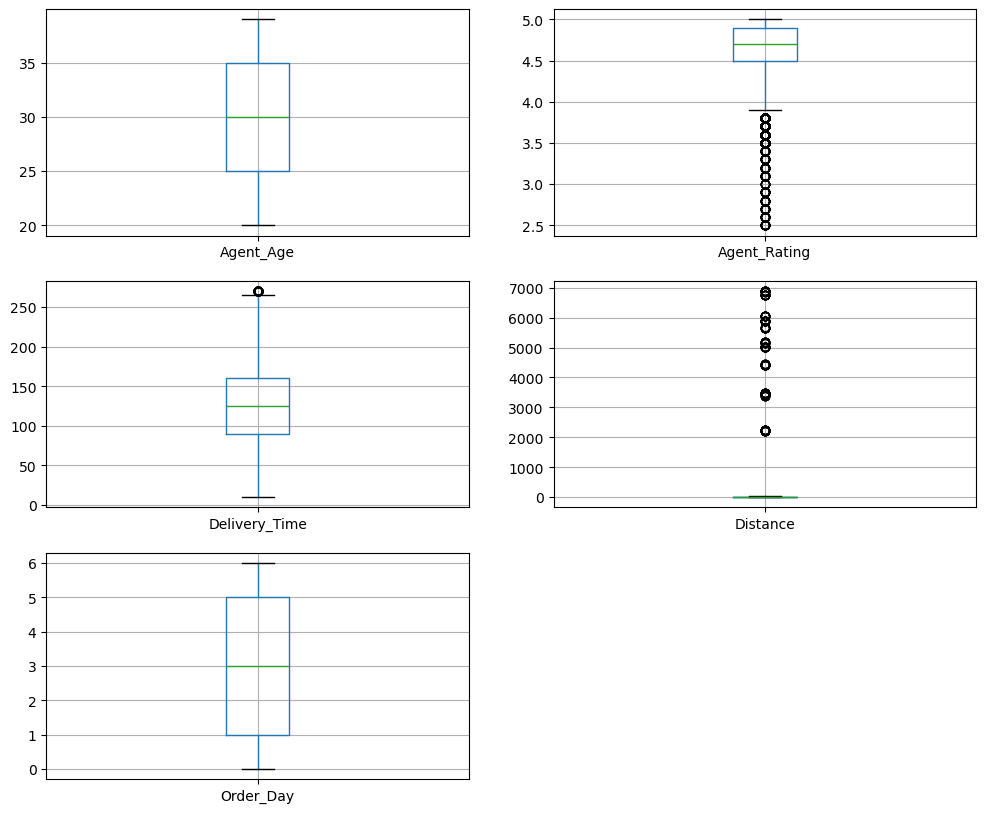

In [21]:
plt.figure(figsize=(12, 10))
for i,col in enumerate(numeric_cols):
    plt.subplot(3,2,i+1)
    df[[col]].boxplot()
plt.show()

In [22]:
df[df["Distance"] > 2000].count()

Agent_Age        151
Agent_Rating     151
Order_Time       151
Pickup_Time      151
Weather          151
Traffic          151
Vehicle          151
Area             151
Delivery_Time    151
Category         151
Distance         151
Order_Day        151
Order_Month      151
dtype: int64

In [23]:
Q1 = np.percentile(df["Distance"],25)
Q3 = np.percentile(df["Distance"],75)
IQR = Q3 - Q1
mini = Q1 - 1.5*IQR
maxi = Q3 + 1.5*IQR
mask = (df["Distance"] < mini) | (df["Distance"] > maxi)
df[mask].index

Index([   90,   275,  1045,  1705,  1893,  2015,  2052,  2112,  2202,  2526,
       ...
       38890, 38917, 39476, 39927, 41869, 42071, 42252, 42824, 43105, 43343],
      dtype='int64', length=151)

In [24]:
df.drop(index = df[mask].index, inplace = True)

In [25]:
Q1 = np.percentile(df["Delivery_Time"],25)
Q3 = np.percentile(df["Delivery_Time"],75)
IQR = Q3 - Q1
mini = Q1 - 1.5*IQR
maxi = Q3 + 1.5*IQR
mask = (df["Delivery_Time"] < mini) | (df["Delivery_Time"] > maxi)
df[mask].index
df.drop(index = df[mask].index, inplace = True)

We are only going to handle distance and delivery time outliers, rest should be fine, because it is normal to give bad ratings for delivery agent

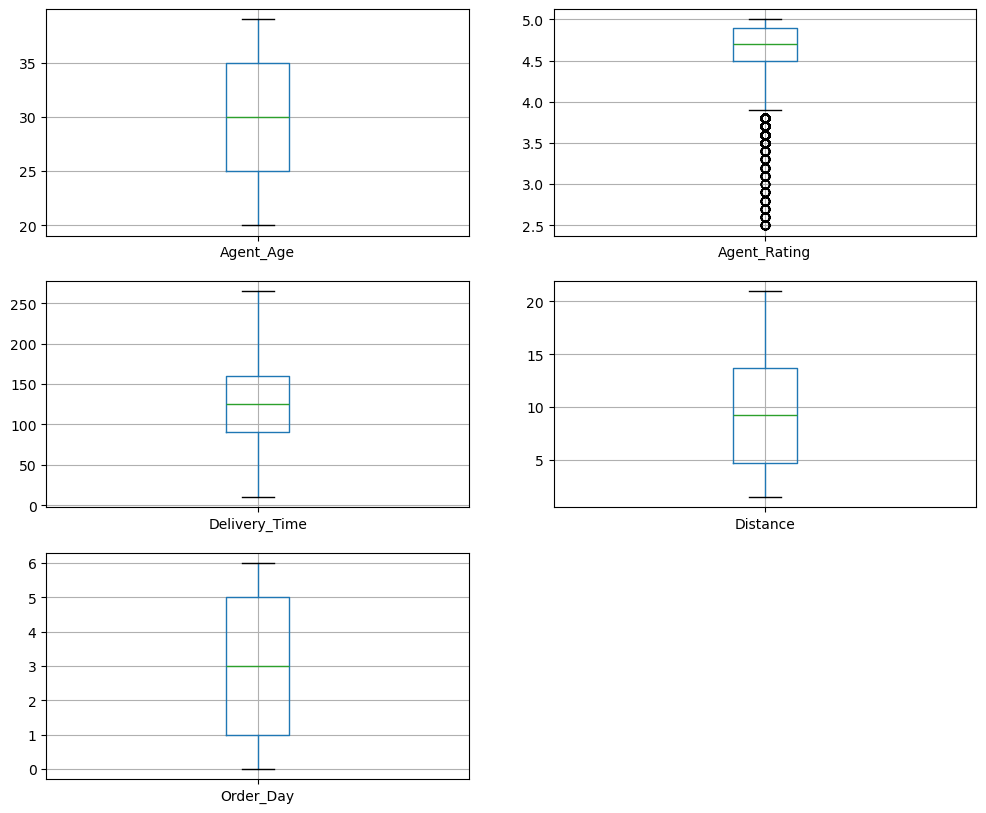

In [26]:
plt.figure(figsize=(12, 10))
for i,col in enumerate(numeric_cols):
    plt.subplot(3,2,i+1)
    df[[col]].boxplot()
plt.show()

Handling typos

In [27]:
df["Weather"].value_counts()

Weather
Fog           7395
Stormy        7331
Cloudy        7243
Sandstorms    7198
Windy         7172
Sunny         7025
Name: count, dtype: int64

In [28]:
df["Traffic"].value_counts()

Traffic
Low        14918
Jam        13590
Medium     10584
High        4272
Name: count, dtype: int64

In [29]:
df["Vehicle"].value_counts()

Vehicle
motorcycle     25315
scooter        14545
van             3504
Name: count, dtype: int64

In [30]:
df["Area"].value_counts()

Area
Metropolitian     32427
Urban              9670
Other              1131
Semi-Urban          136
Name: count, dtype: int64

In [31]:
df["Category"].value_counts()

Category
Electronics     2830
Books           2799
Jewelry         2780
Toys            2755
Skincare        2751
Snacks          2742
Outdoors        2727
Apparel         2706
Sports          2691
Grocery         2678
Pet Supplies    2663
Home            2659
Cosmetics       2651
Kitchen         2648
Clothing        2645
Shoes           2639
Name: count, dtype: int64

No typos found

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43364 entries, 0 to 43738
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Agent_Age      43364 non-null  int64  
 1   Agent_Rating   43364 non-null  float64
 2   Order_Time     43364 non-null  object 
 3   Pickup_Time    43364 non-null  object 
 4   Weather        43364 non-null  object 
 5   Traffic        43364 non-null  object 
 6   Vehicle        43364 non-null  object 
 7   Area           43364 non-null  object 
 8   Delivery_Time  43364 non-null  int64  
 9   Category       43364 non-null  object 
 10  Distance       43364 non-null  float64
 11  Order_Day      43364 non-null  int32  
 12  Order_Month    43364 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(8)
memory usage: 4.5+ MB


## Variable Transformations

In [33]:
all_cols = set(df.columns)
numeric_cols = set(df.select_dtypes(include = ["int64","int32","float64"]).columns)
categorical_cols = all_cols - numeric_cols
categorical_cols

{'Area',
 'Category',
 'Order_Month',
 'Order_Time',
 'Pickup_Time',
 'Traffic',
 'Vehicle',
 'Weather'}

In [34]:
numeric_cols

{'Agent_Age', 'Agent_Rating', 'Delivery_Time', 'Distance', 'Order_Day'}

In [35]:
cols_to_be_transformed = list(categorical_cols)

In [36]:
df[cols_to_be_transformed].head()

,Traffic,Pickup_Time,Vehicle,Weather,Order_Month,Order_Time,Category,Area
0,High,11:45:00,motorcycle,Sunny,March,11:30:00,Clothing,Urban
1,Jam,19:50:00,scooter,Stormy,March,19:45:00,Electronics,Metropolitian
2,Low,08:45:00,motorcycle,Sandstorms,March,08:30:00,Sports,Urban
3,Medium,18:10:00,motorcycle,Sunny,April,18:00:00,Cosmetics,Metropolitian
4,High,13:45:00,scooter,Cloudy,March,13:30:00,Toys,Metropolitian


In [37]:
df["Weather"].value_counts()

Weather
Fog           7395
Stormy        7331
Cloudy        7243
Sandstorms    7198
Windy         7172
Sunny         7025
Name: count, dtype: int64

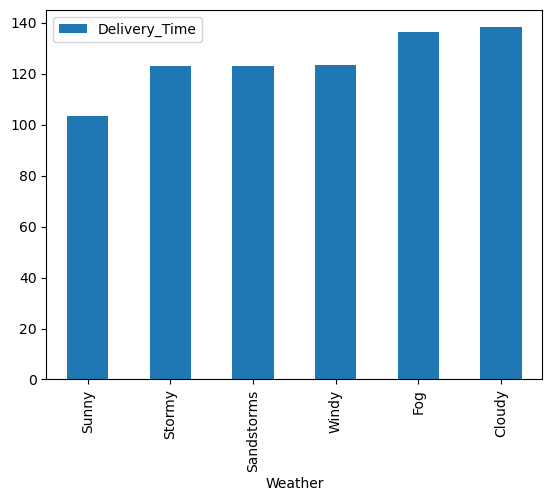

In [38]:
df.groupby("Weather")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

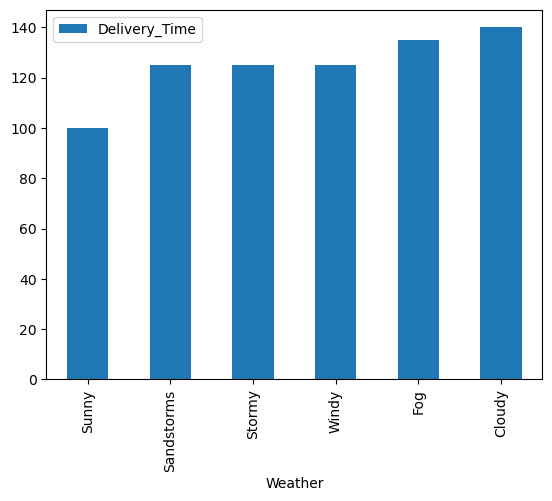

In [39]:
df.groupby("Weather")["Delivery_Time"].median().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

In [40]:
weather = pd.get_dummies(df["Weather"])
weather.replace({True: 1, False: 0},inplace = True)
df = pd.concat([df,weather], axis = 1)
df.drop(columns = ["Weather"], inplace = True)
df.head()

C:\Users\Rishwanth J V K\AppData\Local\Temp\ipykernel_18384\2995181197.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weather.replace({True: 1, False: 0},inplace = True)


,Agent_Age,Agent_Rating,Order_Time,Pickup_Time,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Order_Day,Order_Month,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,37,4.9,11:30:00,11:45:00,High,motorcycle,Urban,120,Clothing,3.025149,5,March,0,0,0,0,1,0
1,34,4.5,19:45:00,19:50:00,Jam,scooter,Metropolitian,165,Electronics,20.183530,4,March,0,0,0,1,0,0
2,23,4.4,08:30:00,08:45:00,Low,motorcycle,Urban,130,Sports,1.552758,5,March,0,0,1,0,0,0
3,38,4.7,18:00:00,18:10:00,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401,1,April,0,0,0,0,1,0
4,32,4.6,13:30:00,13:45:00,High,scooter,Metropolitian,150,Toys,6.210138,5,March,1,0,0,0,0,0


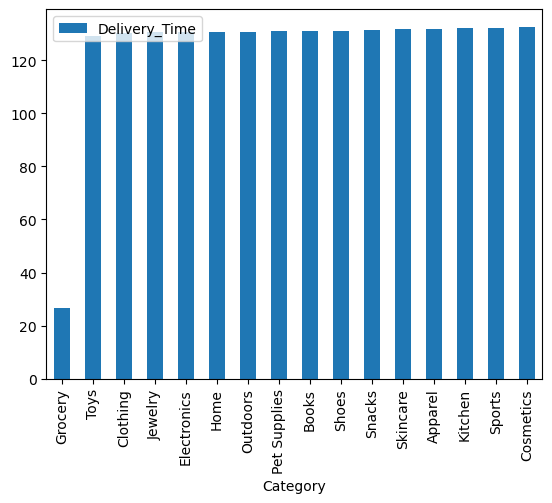

In [41]:
df.groupby("Category")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

In [42]:
df.Category.value_counts()

Category
Electronics     2830
Books           2799
Jewelry         2780
Toys            2755
Skincare        2751
Snacks          2742
Outdoors        2727
Apparel         2706
Sports          2691
Grocery         2678
Pet Supplies    2663
Home            2659
Cosmetics       2651
Kitchen         2648
Clothing        2645
Shoes           2639
Name: count, dtype: int64

Here except for Grocery, all other categories take similar time, so I am categorizing it as grocery and non-grocery 

In [43]:
df["Category"] = np.where(df["Category"] == "Grocery", 0, 1)

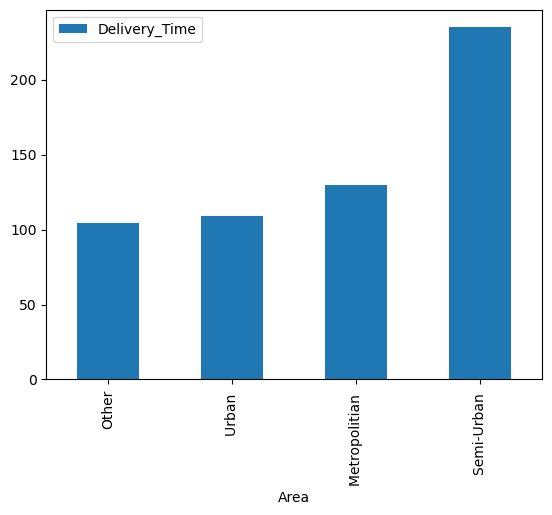

In [44]:
df.groupby("Area")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

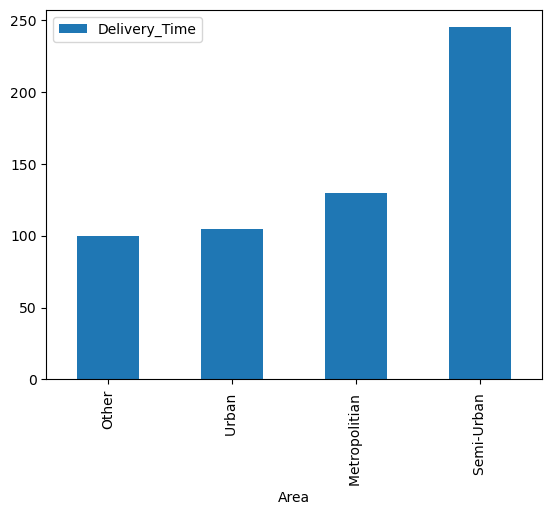

In [45]:
df.groupby("Area")["Delivery_Time"].median().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

In [46]:
df.Area.value_counts()

Area
Metropolitian     32427
Urban              9670
Other              1131
Semi-Urban          136
Name: count, dtype: int64

In [47]:
df.Area.unique().tolist()
df.Area = df.Area.str.strip()

In [48]:
area = pd.get_dummies(df["Area"])
area.replace({True: 1, False: 0},inplace = True)
df = pd.concat([df,area], axis = 1)
df.drop(columns = ["Area"], inplace = True)
df.head()

C:\Users\Rishwanth J V K\AppData\Local\Temp\ipykernel_18384\1384935472.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  area.replace({True: 1, False: 0},inplace = True)


,Agent_Age,Agent_Rating,Order_Time,Pickup_Time,Traffic,Vehicle,Delivery_Time,Category,Distance,Order_Day,...,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy,Metropolitian,Other,Semi-Urban,Urban
0,37,4.9,11:30:00,11:45:00,High,motorcycle,120,1,3.025149,5,...,0,0,0,0,1,0,0,0,0,1
1,34,4.5,19:45:00,19:50:00,Jam,scooter,165,1,20.183530,4,...,0,0,0,1,0,0,1,0,0,0
2,23,4.4,08:30:00,08:45:00,Low,motorcycle,130,1,1.552758,5,...,0,0,1,0,0,0,0,0,0,1
3,38,4.7,18:00:00,18:10:00,Medium,motorcycle,105,1,7.790401,1,...,0,0,0,0,1,0,1,0,0,0
4,32,4.6,13:30:00,13:45:00,High,scooter,150,1,6.210138,5,...,1,0,0,0,0,0,1,0,0,0


In [49]:
df.groupby("Traffic")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time")

,Delivery_Time
Traffic,
Low,101.365129
Medium,126.850151
High,129.262406
Jam,147.114054


In [50]:
df.Traffic = df.Traffic.str.strip()

In [51]:
df.Traffic.unique().tolist()

['High', 'Jam', 'Low', 'Medium']

In [52]:
df.Traffic.value_counts()

Traffic
Low       14918
Jam       13590
Medium    10584
High       4272
Name: count, dtype: int64

In [53]:
oe = OrdinalEncoder(categories = [["Low",'Medium','High','Jam']])

df["Traffic"] = pd.Series(
    oe.fit_transform(df[["Traffic"]]).flatten(),
    index=df.index
)


In [54]:
df.head()

,Agent_Age,Agent_Rating,Order_Time,Pickup_Time,Traffic,Vehicle,Delivery_Time,Category,Distance,Order_Day,...,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy,Metropolitian,Other,Semi-Urban,Urban
0,37,4.9,11:30:00,11:45:00,2.0,motorcycle,120,1,3.025149,5,...,0,0,0,0,1,0,0,0,0,1
1,34,4.5,19:45:00,19:50:00,3.0,scooter,165,1,20.183530,4,...,0,0,0,1,0,0,1,0,0,0
2,23,4.4,08:30:00,08:45:00,0.0,motorcycle,130,1,1.552758,5,...,0,0,1,0,0,0,0,0,0,1
3,38,4.7,18:00:00,18:10:00,1.0,motorcycle,105,1,7.790401,1,...,0,0,0,0,1,0,1,0,0,0
4,32,4.6,13:30:00,13:45:00,2.0,scooter,150,1,6.210138,5,...,1,0,0,0,0,0,1,0,0,0


In [55]:
df.groupby("Vehicle")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time")

,Delivery_Time
Vehicle,
van,116.235731
scooter,116.362599
motorcycle,130.612364


In [56]:
df["Vehicle"] = df["Vehicle"].str.strip()
df["Vehicle"].unique().tolist()

['motorcycle', 'scooter', 'van']

In [57]:
vehicle = pd.get_dummies(df["Vehicle"])
vehicle.replace({True: 1, False: 0},inplace = True)
df = pd.concat([df,vehicle], axis = 1)
df.drop(columns = ["Vehicle"], inplace = True)
df.head()

C:\Users\Rishwanth J V K\AppData\Local\Temp\ipykernel_18384\3598443659.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vehicle.replace({True: 1, False: 0},inplace = True)


,Agent_Age,Agent_Rating,Order_Time,Pickup_Time,Traffic,Delivery_Time,Category,Distance,Order_Day,Order_Month,...,Stormy,Sunny,Windy,Metropolitian,Other,Semi-Urban,Urban,motorcycle,scooter,van
0,37,4.9,11:30:00,11:45:00,2.0,120,1,3.025149,5,March,...,0,1,0,0,0,0,1,1,0,0
1,34,4.5,19:45:00,19:50:00,3.0,165,1,20.183530,4,March,...,1,0,0,1,0,0,0,0,1,0
2,23,4.4,08:30:00,08:45:00,0.0,130,1,1.552758,5,March,...,0,0,0,0,0,0,1,1,0,0
3,38,4.7,18:00:00,18:10:00,1.0,105,1,7.790401,1,April,...,0,1,0,1,0,0,0,1,0,0
4,32,4.6,13:30:00,13:45:00,2.0,150,1,6.210138,5,March,...,0,0,0,1,0,0,0,0,1,0


In [58]:
df.drop(columns = ["Order_Time","Pickup_Time"],inplace = True)

In [59]:
df.head()

,Agent_Age,Agent_Rating,Traffic,Delivery_Time,Category,Distance,Order_Day,Order_Month,Cloudy,Fog,...,Stormy,Sunny,Windy,Metropolitian,Other,Semi-Urban,Urban,motorcycle,scooter,van
0,37,4.9,2.0,120,1,3.025149,5,March,0,0,...,0,1,0,0,0,0,1,1,0,0
1,34,4.5,3.0,165,1,20.183530,4,March,0,0,...,1,0,0,1,0,0,0,0,1,0
2,23,4.4,0.0,130,1,1.552758,5,March,0,0,...,0,0,0,0,0,0,1,1,0,0
3,38,4.7,1.0,105,1,7.790401,1,April,0,0,...,0,1,0,1,0,0,0,1,0,0
4,32,4.6,2.0,150,1,6.210138,5,March,1,0,...,0,0,0,1,0,0,0,0,1,0


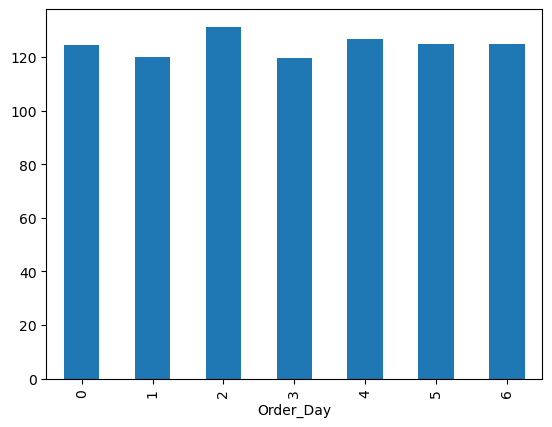

In [60]:
df.groupby("Order_Day")["Delivery_Time"].mean().plot(kind = "bar")
plt.show()

In [61]:
df[["Order_Day","Delivery_Time"]].corr()

,Order_Day,Delivery_Time
Order_Day,1.000000,0.006314
Delivery_Time,0.006314,1.000000


not much correlation between order_day and delivery_time, so we can remove the feature

In [62]:
df.drop(columns = {"Order_Day"},inplace=True)
df.head()

,Agent_Age,Agent_Rating,Traffic,Delivery_Time,Category,Distance,Order_Month,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy,Metropolitian,Other,Semi-Urban,Urban,motorcycle,scooter,van
0,37,4.9,2.0,120,1,3.025149,March,0,0,0,0,1,0,0,0,0,1,1,0,0
1,34,4.5,3.0,165,1,20.183530,March,0,0,0,1,0,0,1,0,0,0,0,1,0
2,23,4.4,0.0,130,1,1.552758,March,0,0,1,0,0,0,0,0,0,1,1,0,0
3,38,4.7,1.0,105,1,7.790401,April,0,0,0,0,1,0,1,0,0,0,1,0,0
4,32,4.6,2.0,150,1,6.210138,March,1,0,0,0,0,0,1,0,0,0,0,1,0


In [63]:
df.groupby("Order_Month")["Delivery_Time"].count()

Order_Month
April        6078
February     6753
March       30533
Name: Delivery_Time, dtype: int64

In [64]:
df.drop(columns = {"Order_Month"},inplace=True)
df.head()

,Agent_Age,Agent_Rating,Traffic,Delivery_Time,Category,Distance,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy,Metropolitian,Other,Semi-Urban,Urban,motorcycle,scooter,van
0,37,4.9,2.0,120,1,3.025149,0,0,0,0,1,0,0,0,0,1,1,0,0
1,34,4.5,3.0,165,1,20.183530,0,0,0,1,0,0,1,0,0,0,0,1,0
2,23,4.4,0.0,130,1,1.552758,0,0,1,0,0,0,0,0,0,1,1,0,0
3,38,4.7,1.0,105,1,7.790401,0,0,0,0,1,0,1,0,0,0,1,0,0
4,32,4.6,2.0,150,1,6.210138,1,0,0,0,0,0,1,0,0,0,0,1,0


## Model Comparisons

Linear Regression

In [66]:
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [67]:
x = df.drop("Delivery_Time",axis = 1)
y = df.Delivery_Time
ss = StandardScaler()
x = pd.DataFrame(ss.fit_transform(x))

In [68]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size = 0.3, random_state = 42)

Vanilla Linear Regression:

In [69]:
lr = LinearRegression()
lr.fit(train_x,train_y)
pred_y = lr.predict(test_x)
r2_score(pred_y,test_y)

0.3758362413299611

Regularization:

In [70]:
lasso = Lasso(alpha = 0.1, max_iter = 100000)
lasso.fit(train_x,train_y)
pred_y = lasso.predict(test_x)
r2_score(pred_y,test_y)

0.36719785841673136

This means the model is too simple

Polynomial Regression:

In [71]:
poly = PolynomialFeatures(degree = 4)
new_x = poly.fit_transform(x)
train_x,test_x,train_y,test_y = train_test_split(new_x,y,test_size = 0.3, random_state = 42)

In [72]:
lr = LinearRegression()
lr.fit(train_x,train_y)
pred_y = lr.predict(test_x)
r2_score(pred_y,test_y)

0.6896794525013199

In [73]:
pred_y = lr.predict(train_x)
r2_score(train_y,pred_y)

0.777253352616943

## Conclusion

We are able to achieve a r2_score of 0.777 for the training data set and 0.6897 for the testing data set. The vanilla Linear Regression was underfitting, we came to know it was an underfit as when we regularized, r2_score further decreased. Hence we increased the complexity of the model using polynomial regression, which significantly increased the r2_score.

## Flaws and next step

The model is able to explain only 68.96% of the variation, higher r2_score can be achieved by making more complex feature combinations.